In [1]:
# In this file is provided the custom CNN and all the regularization techniques are included.

# Run time: 40 minute(depends on early stopping)

In [2]:
# Used libraries

import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D,Dropout,BatchNormalization,Reshape
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Impose seed for the reproducibility
seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

In [4]:
# Dimension of the resized images and input dimention of the CNN
Target_size = 32

In [5]:
# Paths of the folder of the images and labels, after use to access the files uploaded in the Input
path = "/kaggle/input"
train_path = path + "/Train"
test_path = path + "/Test"
test_csv_path = path + "/Test.csv"

In [6]:
# List of images path to load them
img_list = []
label_train_list = []
folders = os.listdir(train_path)  # directory of the folder containing all the train images

for folder in folders:  # access singularly the 43 folders contained in the train folder
    for img in os.listdir(train_path + "/"+folder): # access singlularly every image contained in the folder
        img_list.append  (train_path +  "/"+ folder+"/"+img) # creates an array with all the images in order of access
        label_train_list.append(folder)                      # creates at the same time an array with the number of the folder accessed (corresponds to the class)

# Sorted numpy array label of the corresponding image
label_train_list = np.array(label_train_list, dtype=int)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/Train'

In [7]:
# Dictionary used for the print of images with the number of the class and the corresponding name
label_name={
0: "Speed Limit 20",  
1: "Speed Limit 30",  
2: "Speed Limit 50",  
3: "Speed Limit 60",  
4: "Speed Limit 70",  
5: "Speed Limit 80",  
6: "End of a Speed Limit 80",  
7: "Speed Limit 100",  
8: "Speed Limit 120",  
9: "No overtaking",  
10: "No overtaking by trucks",  
11: "Crossroads",  
12: "Priority Road",  
13: "Give way",  
14: "Stop", 
15: "All vehicles prohibited in both directions",  
16: "No trucks",  
17: "No Entry",  
18: "Other Hazards",  
19: "Curve to left",  
20: "Curve to right",  
21: "Double curve, first to the left",  
22: "Uneven Road",  
23: "Slippery Road",  
24: "Road Narrows Near Side",  
25: "Roadworks",  
26: "Traffic lights",  
27: "No pedestrians",  
28: "Children",  
29: "Cycle Route",  
30: "Be careful in winter",  
31: "Wild animals",  
32: "No parking",  
33: "Turn right ahead",  
34: "Turn left ahead",  
35: "Ahead Only",  
36: "Proceed straight or turn right",  
37: "Proceed straight or turn left",  
38: "Pass onto right",  
39: "Pass onto left",  
40: "Roundabout",  
41: "No overtaking",  
42: "End of Truck Overtaking Prohibition",  
}

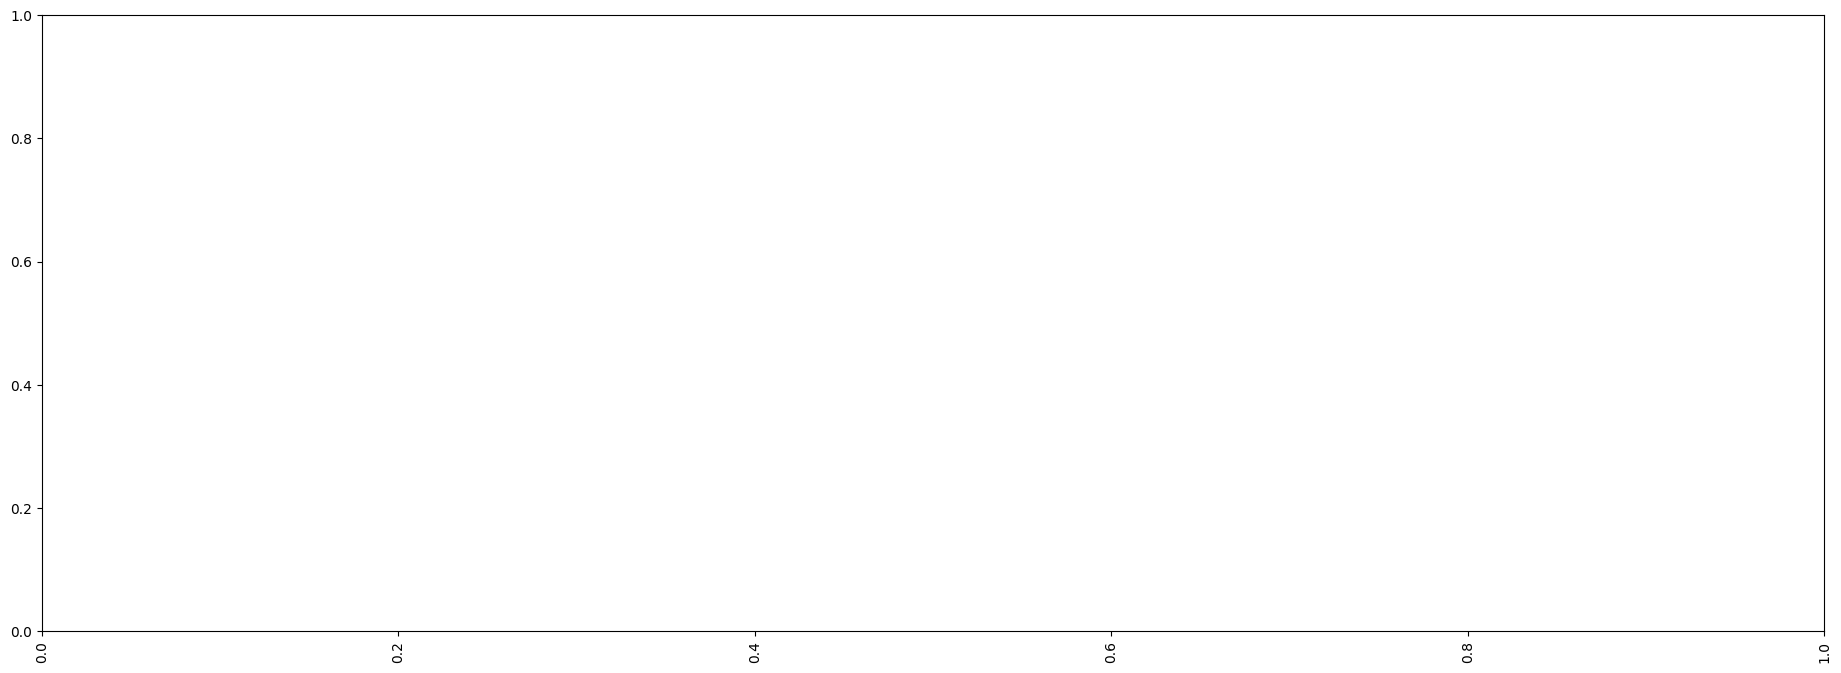

In [8]:
# Dataset visualization -> print of an histogram

df=pd.DataFrame({"img":img_list,"label":label_train_list})     # define a type of data formed by couples
df["label"]=df["label"].astype(int)                            # changes the type of the label column
df["actual_label"]=df["label"].map(label_name)                 # creates a new column with the name of the classes mapped exaclty in the row of the corresponding clas

plt.figure(figsize=(23,8))                                            # create the images

ax = sns.countplot(      x = df["actual_label"],                      # on the x axis the names of the classes
                   palette = "viridis",                               # how to cloror the histogram
                     order = df['actual_label'].value_counts().index) # counts the number of elements with the same name of class

for p in ax.containers:
    ax.bar_label(p, fontsize=12, color='black', padding=5)            # for each column of the histogram add a label of the corresponding value
    
plt.xticks(rotation=90);                                              # rotates the graphs of 90°

In [9]:
# Function for loading and resizing the images  
def process_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # decode image as RGB
    img = tf.image.resize(img, [Target_size, Target_size], method=tf.image.ResizeMethod.BILINEAR)
    img = img / 255.0  # Normalization
    return img, label

# Create a dataset with images and labels
dataset = tf.data.Dataset.from_tensor_slices((img_list, label_train_list)) #It takes each pair (image, label) and transforms it into a dataset of individual elements.

# Pre-processing of the dataset
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# with .map tensorflow apply at each couple image+label in dataset the function process_image
# num_parallel_calls specifies how many parallel threads to use to apply the process_image function.
# Using tf.data.AUTOTUNE, TensorFlow automatically optimizes the number of threads based on available hardware resources 
# to maximize performance.

TypeError: in user code:

    File "C:\Users\OM SAH\AppData\Local\Temp\ipykernel_8988\2762956981.py", line 3, in process_image  *
        img = tf.io.read_file(img_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
# Model definition

l2_lambda = 0.0001  # value for the regularizer

model=Sequential()
model.add(Input(shape=(Target_size,Target_size,3)))

model.add(Conv2D(64,kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(43,activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Model compilation
opt      = keras.optimizers.Adam(learning_rate = 1e-3, ema_momentum=0.95)     # Adam used as pìoptimizez
loss_fcn = keras.losses.SparseCategoricalCrossentropy()                       # Sparse Categorical Crossentropy used as loss function

model.compile(optimizer = opt,                                                # compiling the model
              loss      = loss_fcn,
              metrics   = ['accuracy'])

In [ ]:
# Split of the dataset into train e validation set with a rate of 20%

split = 0.2

dataset_size = len(list(dataset)) 
train_size = int((1 - split) * dataset_size)

dataset = dataset.shuffle(buffer_size=dataset_size, seed=seed) # shuffle the data

train_dataset = dataset.take(train_size)  # keep the first 80% of the dataset
val_dataset = dataset.skip(train_size)    # Skip the data kept for the training,set

In [ ]:
# Data augmentation: 
# random rotation of 5% from original image
# random translation of 10% from original image
# random zoom of 10% from original image

data_augmentation = Sequential([
                      keras.layers.RandomRotation(0.05),
                      keras.layers.RandomTranslation(0.1,0.1),
                      keras.layers.RandomZoom(0.1)
])

In [ ]:
batch_size = 128 # Use the same batch size for the mapping of the images and for the fitting of the model to avoid bottleneck and memory loss

# Apply of data augmentation only to the training images (there is no risk of misalignment).
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Data's batching and loading optimization
train_dataset = train_dataset.shuffle(buffer_size=int(train_dataset.cardinality()), seed=seed).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) # no shuffle on validation set, we want to compare results
# method prefetch: while the GPU trains the current batch, the CPU preloads the next batch.

In [ ]:
# Two callbacks: reduce learning rate and early stopping(so number of epochs are raised)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, min_delta=0.005)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

# Patience indicates the number of epochs without improvements before stopping the training.  
# The patience of early stopping must be set greater than the patience of reduce_lr.  
# Factor represents the reduction factor of the learning rate when the monitored metric (val_loss in your case) stops improving.  
# The learning rate controls the step size that the optimization algorithm takes in the direction of minimizing the loss function.  
# Val_loss is monitored to prevent overfitting.
# min_delta is set to indicate when to apply the callback.

# Example for the reduce learning rate: if there isn't a decrement on the validation loss of 0.005(=min_delta) with respect to the previous 2(=patience) epochs
# the learning rate will be halved

In [ ]:
# Model Fit

n_epochs   = 50 # very high number of epochs but early stopping prevents useless epochs saving time 
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    callbacks       = [reduce_lr, early_stopping],
                    verbose         = 1   
                   )

In [ ]:
# Plot of the training graphs: accuracy and loss

print(type(history))
if type(history) != dict:
    history = history.history

plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1)
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

# print fo the training values
print("Accuracy: ", history["accuracy"][-1])
print("Validation Accuracy: ", history["val_accuracy"][-1])

print("Loss: ", history["loss"][-1])
print("Validation Loss: ", history["val_loss"][-1])

# prints optimal capacity -> at which epoch the model had the higher validation accuracy
print("Optimal Capacity: ", np.argmax(history["val_accuracy"]) + 1)

In [ ]:
# Obtaining test labels and correspective images' paths

test = pd.read_csv(test_csv_path)   # reads the csv file containing the labels in a data structor that has as columns ClassId and Path
test_labels=[]
test_path=[]
for i in range(len(test)):                          # for every row are saved (in order) in two arrays, the class id and the path of the image
    test_labels.append(test["ClassId"][i])
    test_path.append(path +'/' + test["Path"][i])

test_labels = np.array(test_labels,dtype=int)       # trasforms the labels in integers

In [ ]:
# Create test set 
test_dataset = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# Pre-processing of test set
test_dataset = test_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch to speed-up the test
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Generate prediction of the model
predictions = model.predict(test_dataset)

# Get the class with the highest probability for each prediction
predictions = np.argmax(predictions, axis=-1)

# Compute the accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
# Extract the images and the labels
test_dataset_unbatched = test_dataset.unbatch()
x_test, y_test = zip(*test_dataset_unbatched)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# Plot of 10 random images with corresponding prediction and true labels

plt.figure(figsize=(25, 25))

indices = random.sample(range(0, len(x_test)), 10)

j=0
for i in indices:
    j+=1
    plt.subplot(5, 5, j)
    plt.imshow(x_test[i])
    plt.title("True: {} {}\n Predicted: {} {}".format(y_test[i], label_name[y_test[i]],predictions[i], label_name[predictions[i]]) )
    plt.axis("off")